100%|██████████| 10000/10000 [00:01<00:00, 8447.47it/s]


N-Groundtrouth: 10000, N-Interpolated: 1000
Interpolation method: linear
Sill: 31000, Rang: 74000, Nugget: 400

Simple Kriging NN=4 NR=None R2: 0.9189527019610035
Ordinary Kriging NN=4 NR=None R2: 0.9316616466496838
IDW Power 3 R2: 0.9345264513747584

Simple Kriging NN=4 NR=None RMSE: 37.282406868132966
Ordinary Kriging NN=4 NR=None RMSE: 34.23473151172276
IDW Power 3 RMSE: 33.50947403834284


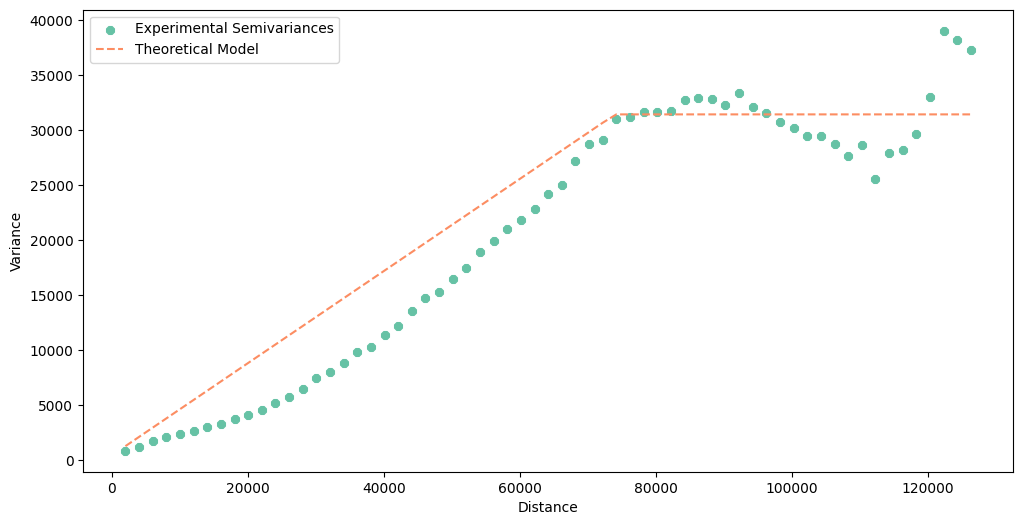

(None, None)

In [470]:
#-- my_code_hw03.py
#-- hw03 GEO1015.2022
#-- [Malte Schade]
#-- [5850282] 


# IMPORTS

import numpy as np

import rasterio
from rasterio.io import MemoryFile
from rasterio.warp import calculate_default_transform, reproject

from pyinterpolate import calc_point_to_point_distance, build_theoretical_variogram, kriging, inverse_distance_weighting
from pyinterpolate import VariogramCloud, ExperimentalVariogram, TheoreticalVariogram

from sklearn.metrics import mean_squared_error, r2_score

import plotly.express as px
import plotly.graph_objects as go


# CONSTANTS

seed = 12345678                 # numpy RNG seed
path = 'N51E007.hgt'            # SRTM dataset path (.hgt)
dst_crs = 'EPSG:32632'          # transformed coordinate reference system
no_data_f = -1000               # NODATA numerical value threshold
n_gt = 10000                    # number of random ground-truth points
n_in = 1000                     # number of random points used for interpolation
norm_std = (10, 10, 16)         # standard deviations in all three spacial dimensions
vc_lag = 64                     # lag number in variogram cloud / experimental variogram
model = 'linear'                # theoretical variogram model
nn = 4                          # kriging number of neighbors
nr = None                       # kriging maximum range for neighbors
power = 3                       # IDW power
nbins = 100                     # visualization histogram bin count

sill = 31000                    # sill (from experimental variogram)
rang = 74000                    # rang (from experimental variogram)
nugget = 400                    # nugget (from experimental variogram)


# FUNCTIONS

def reproject_dataset(src, dst_crs):
    # Calculate transformation parameters
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    
    kwargs = src.meta.copy()
    kwargs.update({
        'driver': 'GTiff',
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with MemoryFile() as memfile:
        with memfile.open(**kwargs) as dst:
            reproject(
                source=rasterio.band(src, 1),
                destination=rasterio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs
                )
            
        return memfile.open()


def add_noise(data, std_x, std_y, std_z):
    # Generate normal noise for each dimension
    noise_x = np.random.normal(0, std_x, data.shape[0])
    noise_y = np.random.normal(0, std_y, data.shape[0])
    noise_z = np.random.normal(0, std_z, data.shape[0])
    
    # Add noise to data
    data[:,0] += noise_x
    data[:,1] += noise_y
    data[:,2] += noise_z
    
    return data


def scatterplot_2d(data, title, xlabel, ylabel, zlabel):
    # Create figure
    fig = go.Figure()

    # Add scatterplot to figure
    fig.add_trace(go.Scatter(
    x=data[:,0], 
    y=data[:,1], 
    mode="markers", 
    marker=dict(
    size=6,
    color=data[:,2],
    colorscale="Viridis",
    colorbar=dict(title=zlabel)
    )))

    # Set figure layout
    fig.update_layout(
    title=title,
    xaxis_title=xlabel,
    yaxis_title=ylabel,
    )
    
    # Fix aspect ratio to 1/1
    fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1
    )
    
    return fig


# MAIN PIPELINE

# Seed the RNG
np.random.seed(seed)

# Open raster dataset
data = rasterio.open(path)

# Project data to new CRS
data = reproject_dataset(data, dst_crs)

# Extract x/y/z coordinates
cols, rows = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
xs, ys  = rasterio.transform.xy(data.transform, rows, cols)
zs = data.read(1)
p_data = np.reshape(np.stack([xs, ys, zs], axis=2), [xs.__len__()*xs[0].__len__(), 3])

# Filter no-data values
p_data = p_data[p_data[:,2]>no_data_f]

# Select interpolation points 
p_in = p_data[np.random.choice(p_data.shape[0], n_in, replace=False)]

# Select ground-truth points
p_gt = p_data[np.random.choice(p_data.shape[0], n_gt, replace=False)]

# Define interpolation array without z-coordinates
p_new = p_gt[:,:2]

# Apply normal noise to interpolation points
p_in = add_noise(p_in, *norm_std)

# Calculate point distance matrix
d_in = calc_point_to_point_distance(p_in)

# Calculate variogram cloud (Time Intensive!)
# vc_in = VariogramCloud(input_array=p_in, step_size=np.max(d_in)/vc_lag, max_range=np.max(d_in))

# Calculate experimental variogram
ev_in = ExperimentalVariogram(input_array=p_in, step_size=np.max(d_in)/vc_lag, max_range=np.max(d_in))

# fit theoretical variogram to variance data
tv_in = TheoreticalVariogram()
fitted = tv_in.autofit(ev_in, sill=sill, rang=rang, nugget=nugget, model_types=model)

# simple kriging
sk = kriging(p_in, tv_in, p_new, how='sk', sk_mean=p_gt[:,2].mean(), no_neighbors=nn, neighbors_range=nr)

# ordinary kriging
ok = kriging(p_in, tv_in, p_new, how='ok', no_neighbors=nn, neighbors_range=nr)

# inverse distance power
idw = np.zeros((p_new.__len__(), 3))
idw[:,[0,1]] = p_new
idw[:, 2] = [inverse_distance_weighting(p_in, p_n, power=power) for p_n in p_new]


# EVALUATION

print(f'N-Groundtrouth: {p_gt.__len__()}, N-Interpolated: {p_in.__len__()}')
print(f'Interpolation method: {fitted["model_type"]}')
print(f'Sill: {sill}, Rang: {rang}, Nugget: {nugget}\n')

sk_r2 = r2_score(p_gt[:,2], sk[:,0])
ok_r2 = r2_score(p_gt[:,2], ok[:,0])
idw_r2 = r2_score(p_gt[:,2], idw[:,2])
print(f'Simple Kriging NN={nn} NR={nr} R2: {sk_r2}')
print(f'Ordinary Kriging NN={nn} NR={nr} R2: {ok_r2}')
print(f'IDW Power {power} R2: {idw_r2}\n')

sk_rmse = mean_squared_error(p_gt[:,2], sk[:,0], squared=False)
ok_rmse = mean_squared_error(p_gt[:,2], ok[:,0], squared=False)
idw_rmse = mean_squared_error(p_gt[:,2], idw[:,2], squared=False)
print(f'Simple Kriging NN={nn} NR={nr} RMSE: {sk_rmse}')
print(f'Ordinary Kriging NN={nn} NR={nr} RMSE: {ok_rmse}')
print(f'IDW Power {power} RMSE: {idw_rmse}')


# VISUALIZATION

fig_gt = scatterplot_2d(p_gt, "Scatterplot ground-truth points", "x [m]", "y [m]", "z [m]")
fig_in = scatterplot_2d(p_in, "Scatterplot interpolation points", "x [m]", "y [m]", "z [m]")
fig_ev = scatterplot_2d(ev_in.experimental_semivariance_array, "Experimental Semivariance plot", "Distance [m]", "Variance [m^2]", "n [-]")
fig_skh = px.histogram(sk[:,0], nbins=nbins, title= 'Simple Kriging Result Histogram')
fig_skr = scatterplot_2d(sk[:,[2,3,0]], "Simple Kriging Result", "x [m]", "y [m]", "z [m]")
fig_ske = scatterplot_2d(sk[:,[2,3,1]], "Simple Kriging Variance Error", "x [m]", "y [m]", "Variance Error [m^2]")
fig_okh = px.histogram(ok[:,0], nbins=nbins, title= 'Ordinary Kriging Result Histogram')
fig_okr = scatterplot_2d(ok[:,[2,3,0]], "Ordinary Kriging Result", "x [m]", "y [m]", "z [m]")
fig_oke = scatterplot_2d(ok[:,[2,3,1]], "Ordinary Kriging Variance Error", "x [m]", "y [m]", "Variance Error [m^2]")
fig_idwh = px.histogram(idw[:,2], nbins=nbins, title= f'IDW Power {power} Result Histogram')
fig_idwr = scatterplot_2d(idw, f"IDW Power {power} Result", "x [m]", "y [m]", "z [m]")
#(fig_gt.show(), fig_in.show())
#vc_in.plot()
(fig_ev.show(), tv_in.plot())
#(fig_skh.show(), fig_skr.show(), fig_ske.show())
#(fig_okh.show(), fig_okr.show(), fig_oke.show())
#(fig_idwh.show(), fig_idwr.show())
